In [13]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

In [14]:
from __future__ import division
import numpy as np
from scipy.constants import mu_0, pi, epsilon_0
from scipy.special import erf
from SimPEG import Utils

def Qfun(R, L, f, alpha=None):
    if alpha is None:
        omega = np.pi*2*f
        tau = L/R
        alpha = omega*tau
    Q = (alpha**2+1j*alpha) / (1+alpha**2)
    return alpha, Q

def Mijfun(x,y,z,incl,decl,x1,y1,z1,incl1,decl1, area=1.,area0=1.):
    """
        Compute mutual inductance between two loops

        This

        Parameters
        ----------
        x : array
            x location of the Tx loop
        y : array
            y location of the Tx loop
        z : array
            z location of the Tx loop
        incl:
            XXX
        decl:
            XXX
        x1 : array
            XXX
        y1 : array
            XXX
        z1 : array
            XXX
        incl1:
            XXX
        decl1:
            XXX
    """

    # Pretty sure below assumes dipole
    x = np.array(x, dtype=float)
    y = np.array(y, dtype=float)
    z = np.array(z, dtype=float)
    x1 = np.array(x1, dtype=float)
    y1 = np.array(y1, dtype=float)
    z1 = np.array(z1, dtype=float)
    incl = np.array(incl, dtype=float)
    decl = np.array(decl, dtype=float)
    incl1 = np.array(incl1, dtype=float)
    decl1 = np.array(decl1, dtype=float)


    di=np.pi*incl/180.0
    dd=np.pi*decl/180.0

    cx=np.cos(di)*np.cos(dd)
    cy=np.cos(di)*np.sin(dd)
    cz=np.sin(di)


    ai=np.pi*incl1/180.0
    ad=np.pi*decl1/180.0

    ax=np.cos(ai)*np.cos(ad)
    ay=np.cos(ai)*np.sin(ad)
    az=np.sin(ai)

    # begin the calculation
    a=x-x1
    b=y-y1
    h=z-z1

    rt=np.sqrt(a**2.+b**2.+h**2.)**5.

    txy=3.*a*b/rt
    txz=3.*a*h/rt
    tyz=3.*b*h/rt

    txx=(2.*a**2.-b**2.-h**2.)/rt
    tyy=(2.*b**2.-a**2.-h**2.)/rt
    tzz=-(txx+tyy)

    scale = mu_0*np.pi*area*area0/4
    # scale = 1.

    bx= (txx*cx+txy*cy+txz*cz)
    by= (txy*cx+tyy*cy+tyz*cz)
    bz= (txz*cx+tyz*cy+tzz*cz)

    return scale*(bx*ax+by*ay+bz*az)

def Cfun(L,R,xc,yc,zc,incl,decl,S,ht,f,xyz):
    """
        Compute coupling coefficients

        .. math::
            - \frac{M_{12} M_{23}}{M_{13}L_2}

        Parameters
        ----------

    """
    L = np.array(L, dtype=float)
    R = np.array(R, dtype=float)
    xc = np.array(xc, dtype=float)
    yc = np.array(yc, dtype=float)
    zc = np.array(zc, dtype=float)
    incl = np.array(incl, dtype=float)
    decl = np.array(decl, dtype=float)
    S = np.array(S, dtype=float)
    f = np.array(f, dtype=float)

    # This is a bug, hence needs to be fixed later
    x = xyz[:,1]
    y = xyz[:,0]
    z = xyz[:,2]

    # simulate anomalies
    yt=y-S/2.
    yr=y+S/2.

    dm=-S/2.
    dp= S/2.

    # Computes mutual inducances
    # Mijfun(x,y,z,incl,decl,x1,y1,z1,incl1,decl1)
    M13=Mijfun(0.,dm,0.,90.,0., 0., dp, 0., 90.,0.)
    M12=Mijfun(x,yt,z,90.,0.,xc,yc,zc,incl,decl,area=1.,area0=3.)
    M23=Mijfun(xc,yc,zc,incl,decl,x,yr,z,90.,0.,area=3.,area0=1.)

    C = -M12*M23/(M13*L)
    return C, M12, M23, M13*np.ones_like(C)

In [15]:
# from em_examples.EMcircuit import Mijfun, Cfun, Qfun
from SimPEG.EM.Analytics.FDEM import MagneticDipoleWholeSpace

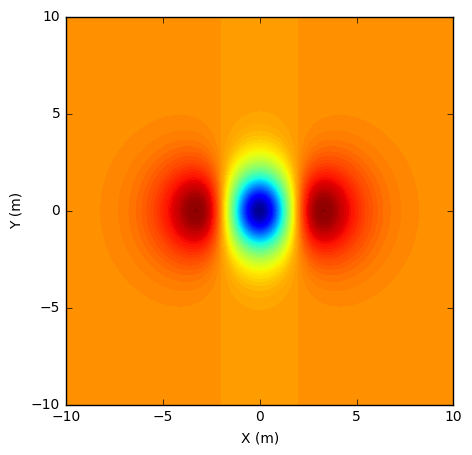

In [16]:
L = 1.
R = 2000.
xc = 0.
yc = 0.
zc = 4.
incl = 0.
decl = 90.
S = 4.
ht = 0.
f = 10000.
xmin = -10.
xmax = 10.
dx = 0.25
xp = np.linspace(xmin, xmax, 101)
yp = xp.copy()
zp = np.r_[-ht]
[X, Y] = np.meshgrid(xp, yp)
xyz = np.c_[X.flatten(), Y.flatten(), np.ones_like(X.flatten())*ht]
c, m12, m23, m13 = Cfun(L,R,xc,yc,zc,incl,decl,S,ht,f,xyz)
C = c.reshape(X.shape)
fig = plt.figure(figsize=(5,5))
plt.contourf(X, Y, C, 100)
plt.xlabel("X (m)")
plt.ylabel("Y (m)")
plt.show()

In [17]:
from scipy.constants import mu_0
bx, by, bz = MagneticDipoleWholeSpace(xyz, np.r_[0., 0., 0.], 1e-8, 1e-8, moment=1., orientation='Y', mu = mu_0)

(-10.0, 10.0, -10.0, 10.0)

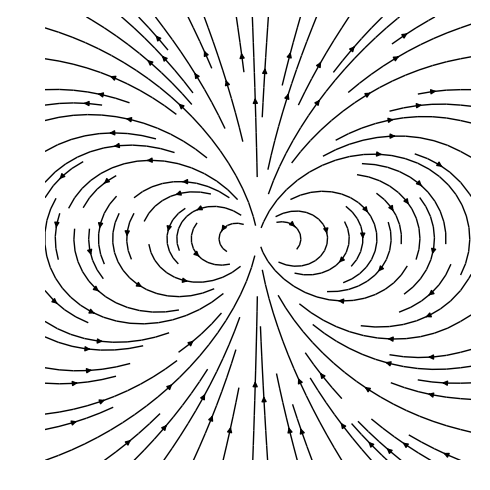

In [18]:
fig = plt.figure(figsize=(5,5))
plt.streamplot(X, Y, (bx.real).reshape(X.shape), (by.real).reshape(Y.shape), color="k")
plt.tight_layout()
plt.axis("off")
# fig.savefig("dipole", dpi=100)

(-10.0, 10.0, -10.0, 10.0)

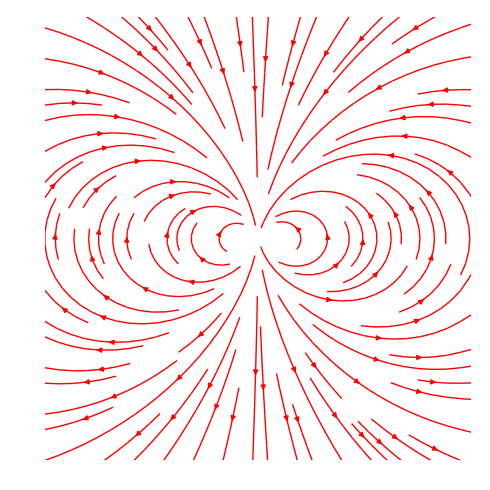

In [19]:
fig = plt.figure(figsize=(5,5))
plt.streamplot(X, Y, -(bx.real).reshape(X.shape), -(by.real).reshape(Y.shape), color="r")
plt.tight_layout()
plt.axis("off")
# fig.savefig("dipole_red", dpi=100)

In [20]:
xyz_profile = np.c_[xp, np.zeros_like(xp), np.ones_like(xp)*ht]
c_profile, m12_profile, m23_profile, m13_profile = Cfun(L,R,xc,yc,zc,incl,decl,S,ht,f,xyz_profile)

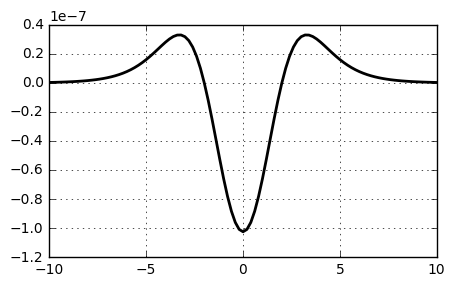

In [21]:
figsize(5, 3)
plt.plot(xp, c_profile, 'k', lw=2)
# plt.plot(xp, )
# plt.plot(xp-S/2, m12_profile, 'b', lw=2)
# plt.plot(xp-S/2, m23_profile, 'r', lw=2)
# plt.plot(xp-S/2, m13_profile, 'g', lw=2)
# plt.plot(xp, np.zeros_like(xp), 'k--', lw=1)
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))

plt.grid(True)

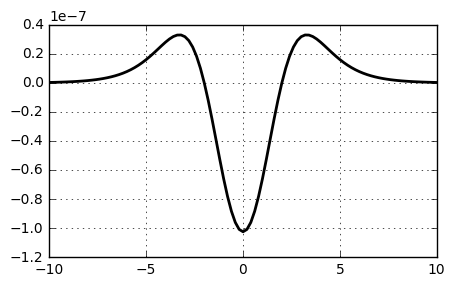

In [22]:
figsize(5, 3)
plt.plot(xp, c_profile, 'k', lw=2)
# plt.plot(xp, m12_profile, 'b', lw=2)
# plt.plot(xp, m23_profile, 'r', lw=2)
# plt.plot(xp, m13_profile, 'g', lw=2)
# plt.plot(xp, np.zeros_like(xp), 'k--', lw=1)
plt.grid(True)

In [48]:
alpha = 0.5
f_factor=(alpha**2.+1j*alpha)/(1+alpha**2.)

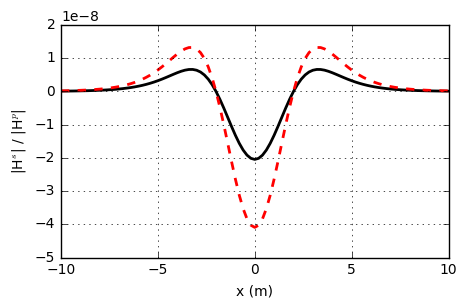

In [49]:
resp = c_profile*f_factor
# figsize(5, 3)
fig, ax = plt.subplots(1,1)
ax.plot(xp, resp.real, 'k', lw=2)
ax.plot(xp, resp.imag, '--r', lw=2)
ax.set_xlabel('x (m)')
ax.set_ylabel('|H$^s$| / |H$^p$|')

# plt.plot(xp, )
# plt.plot(xp-S/2, m12_profile, 'b', lw=2)
# plt.plot(xp-S/2, m23_profile, 'r', lw=2)
# plt.plot(xp-S/2, m13_profile, 'g', lw=2)
# plt.plot(xp, np.zeros_like(xp), 'k--', lw=1)
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
# plt.legend(['real', 'imag'], loc)

plt.grid(True)
fig.savefig('alphahalf.png', bbox_inches="tight", dpi=300)

In [52]:
alpha = np.logspace(-3, 3, 100)
alpha, Q = Qfun(R, L, None, alpha=alpha)

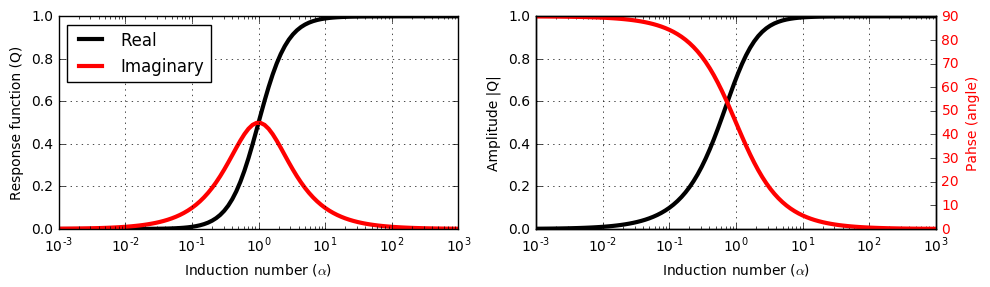

In [53]:
fig = plt.figure(figsize=(10, 3))
ax1 = plt.subplot(121)
ax2 = plt.subplot(122)
ax2_1 = ax2.twinx()
ax1.semilogx(alpha, Q.real, 'k', lw=3)
ax1.semilogx(alpha, Q.imag, 'r', lw=3)
ax1.grid(True)
ax1.legend(("Real","Imaginary"), loc=2)
ax1.set_xlabel("Induction number ($\\alpha$)")
ax1.set_ylabel("Response function (Q)")
ax2.semilogx(alpha, abs(Q), 'k', lw=3)
ax2_1.semilogx(alpha, np.angle(Q, deg=True), 'r', lw=3)
ax2.grid(True)
ax2.set_ylabel("Amplitude |Q|")
ax2_1.set_ylabel('Pahse (angle)', color='r')
ax2.set_xlabel("Induction number ($\\alpha$)")
for tl in ax2_1.get_yticklabels():
    tl.set_color('r')
plt.tight_layout()
plt.show()

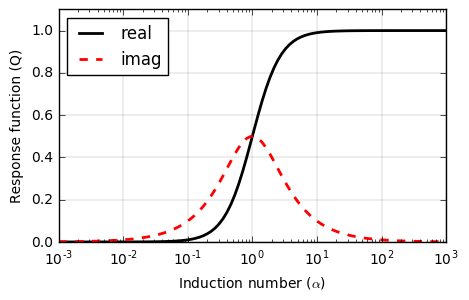

In [54]:
# Plot
fig, ax = plt.subplots(1,1)

ax.semilogx(alpha, Q.real, 'k', linewidth=2)
ax.semilogx(alpha, Q.imag, 'r--', linewidth=2)
ax.grid(True, color='k',linestyle="-", linewidth=0.1)

# ax.semilogx(freqs, dpred_real/b0*1e6)
# ax.semilogx(freqs, dpred_imag/b0*1e6,'--')

ax.legend(("real","imag"), loc=2)
ax.set_xlabel("Induction number ($\\alpha$)")
ax.set_ylabel("Response function (Q)")
ax.set_ylim([0., 1.1])

# ax.legend(['real','imag'], loc='best')
# ax.set_title('Sounding over Sphere')
# ax.set_ylabel('magnetic field (ppm of primary)')
# ax.set_xlabel('frequency (Hz)')

fig.savefig('ResponseFct', dpi=300, bbox_inches="tight")

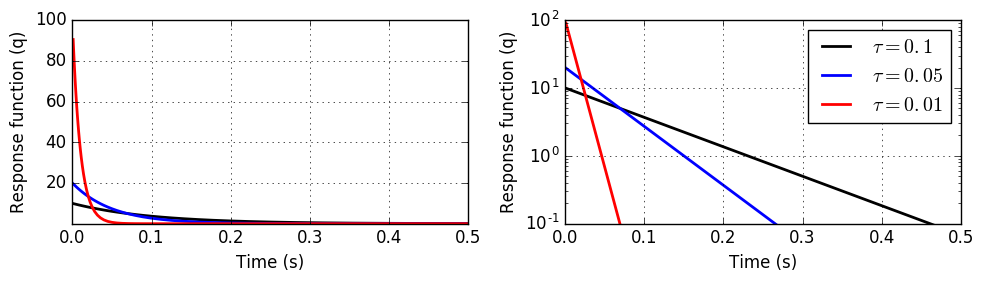

In [117]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['font.size'] = 12
# Time constant
tau = [0.1, 0.05, 0.01]
fig = plt.figure(figsize=(10, 3))
ax1 = plt.subplot(121)
ax2 = plt.subplot(122)
axs = [ax1, ax2]
color = ["k", "b", "r"]
t = np.logspace(-3, 0, 61)

for i in range(3):
    resp = 1./tau[i] * np.exp(-t/tau[i])
    ax1.plot(t, resp, color[i], lw=2)
    ax2.semilogy(t, resp, color[i], lw=2)
for ax in axs:
    ax.grid(True)
    ax.set_ylim(1e-1, 1e2)
    ax.set_xlim(0., 0.5)
    ax.set_xlabel("Time (s)")
    ax.set_ylabel("Response function (q)")
ax2.legend(("$\\tau=0.1$","$\\tau=0.05$", "$\\tau=0.01$"), loc=1)
# ax1.set_title("Log-Log scale")
# ax2.set_title("Lin-Log scale")
plt.tight_layout()
plt.show()

fig.savefig("3loop_TDEM.png", dpi=300, bbox_inches="tight")

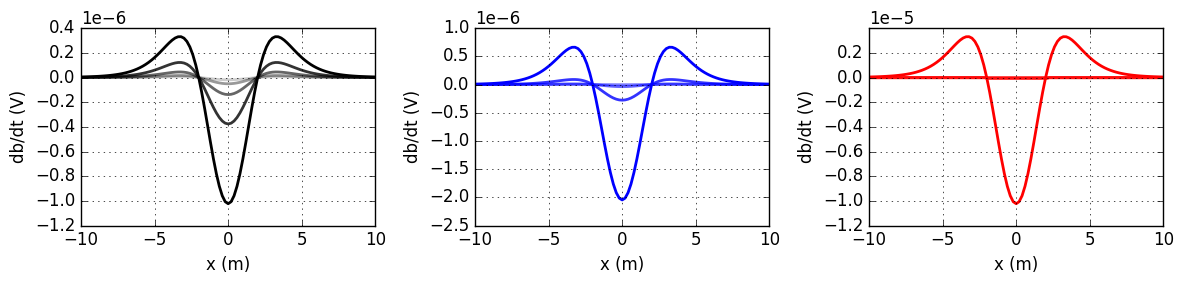

In [123]:
fig, ax = plt.subplots(1, 3, figsize=(12,3))

# ax=[ax]

times = [0, 0.1, 0.2, 0.3, 0.4, 0.5]
tauind = 0

color = ["k", "b", "r"]

for j in range(len(ax)):

    for i, t in enumerate(times):
        resp = 1./tau[j] * np.exp(-t/tau[j]) * c_profile
        ax[j].plot(xp, resp, color[j], alpha=1.-2*t, lw=2)

        ax[j].ticklabel_format(style='sci', axis='y', scilimits=(0,0))
        ax[j].grid(True)
        ax[j].set_xlabel('x (m)')
        ax[j].set_ylabel('db/dt (V)')

plt.tight_layout()
fig.savefig('3time_3loop.png', dpi=300, bbox_inches="tight")
# ax.legend(("$\\tau=0.1$","$\\tau=0.05$", "$\\tau=0.01$"), loc=1)

(-1.2, 1.2)

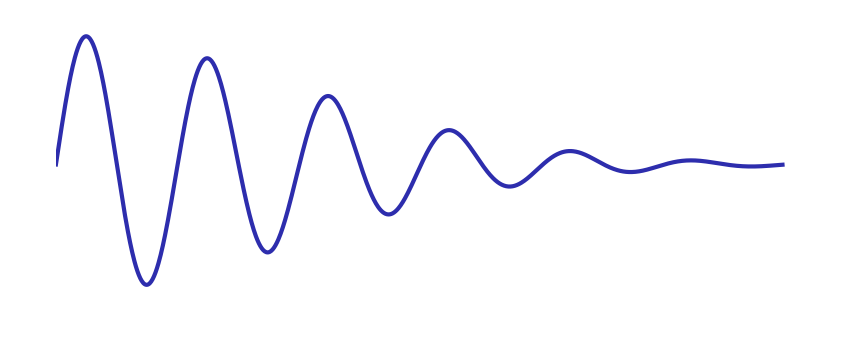

In [176]:
plt.subplots(1,1, figsize=(10,4))
x = np.linspace(0., 15., 1000.)

sinx = np.sin(2.5*x)

# x0 = 3

x0 = 0
x2 = 12
decay = np.exp(-(x-x0)**2/50)
decay[x > x2] = decay[(x > x2).nonzero()[0]]

plt.plot(x, decay*sinx, color=np.r_[44, 44, 170]/250., linewidth=3)
# plt.plot(x, )
plt.axis('off')
plt.ylim([-1.2, 1.2])

array([800, 801, 802, 803, 804, 805, 806, 807, 808, 809, 810, 811, 812,
       813, 814, 815, 816, 817, 818, 819, 820, 821, 822, 823, 824, 825,
       826, 827, 828, 829, 830, 831, 832, 833, 834, 835, 836, 837, 838,
       839, 840, 841, 842, 843, 844, 845, 846, 847, 848, 849, 850, 851,
       852, 853, 854, 855, 856, 857, 858, 859, 860, 861, 862, 863, 864,
       865, 866, 867, 868, 869, 870, 871, 872, 873, 874, 875, 876, 877,
       878, 879, 880, 881, 882, 883, 884, 885, 886, 887, 888, 889, 890,
       891, 892, 893, 894, 895, 896, 897, 898, 899, 900, 901, 902, 903,
       904, 905, 906, 907, 908, 909, 910, 911, 912, 913, 914, 915, 916,
       917, 918, 919, 920, 921, 922, 923, 924, 925, 926, 927, 928, 929,
       930, 931, 932, 933, 934, 935, 936, 937, 938, 939, 940, 941, 942,
       943, 944, 945, 946, 947, 948, 949, 950, 951, 952, 953, 954, 955,
       956, 957, 958, 959, 960, 961, 962, 963, 964, 965, 966, 967, 968,
       969, 970, 971, 972, 973, 974, 975, 976, 977, 978, 979, 98